In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Загрузка и просмотр информации о наборе данных

In [52]:
data = pd.read_csv("S02-hw-dataset.csv")
data.head(5)
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user_id    41 non-null     int64  
 1   age        39 non-null     float64
 2   country    41 non-null     object 
 3   purchases  41 non-null     int64  
 4   revenue    41 non-null     int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 1.7+ KB


,user_id,age,purchases,revenue
count,41.000000,39.000000,41.000000,41.000000
mean,20.243902,36.512821,4.829268,820.048780
std,11.659289,18.304259,2.710189,613.127269
min,1.000000,5.000000,-1.000000,0.000000
25%,10.000000,24.000000,3.000000,432.000000
50%,20.000000,33.000000,5.000000,693.000000
75%,30.000000,45.500000,7.000000,1115.000000
max,40.000000,120.000000,11.000000,2475.000000


Пропуски, дубликаты и базовый контроль качества

In [37]:
print(f"Количество пустых значений:\n{data.isna().sum()}\n")
print(f"Процент пустых значений каждого параметра:\n{data.isna().sum() / data.count()}\n")

duplicated_rows = data.duplicated().sum()
if duplicated_rows > 0:
    print(f"Обнаружено {duplicated_rows} полностью дублирующих строк.")
    print("Пример дубликата:")
    print(data[data.duplicated(keep='first')].head())
else:
    print("Полностью дублирующих строк не обнаружено.")

Количество пустых значений:
user_id      0
age          2
country      0
purchases    0
revenue      0
dtype: int64

Процент пустых значений каждого параметра:
user_id      0.000000
age          0.051282
country      0.000000
purchases    0.000000
revenue      0.000000
dtype: float64

Обнаружено 1 полностью дублирующих строк.
Пример дубликата:
    user_id   age country  purchases  revenue
40       10  24.0      RU          7      511


Подозрительно старые люди

In [44]:
print(data[data['age']>100])

   user_id    age country  purchases  revenue
5        6  120.0      FR         -1      785


Подозрительные доходы

In [46]:
print(data[data['revenue'] <= 0])

    user_id   age country  purchases  revenue
6         7  46.0      RU          0        0
10       11  24.0      US          4        0
17       18  24.0      RU          0        0
33       34  28.0      FR          0        0


Подозрительные покупки

In [72]:
# 1. Создаем булеву маску (Series)
condition = (data['purchases'] > data['revenue']) | (data['purchases'] <= 0)
result = data.loc[condition]
result.head(10)

,user_id,age,country,purchases,revenue
5,6,120.0,FR,-1,785
6,7,46.0,RU,0,0
10,11,24.0,US,4,0
17,18,24.0,RU,0,0
33,34,28.0,FR,0,0


Базовый EDA выявил несколько базовых проблем:
    1. В данных присутствуют полностью повторяющиеся строки и пустые значения
    2. Для всех колонок были найдены подозрительные значения (например, слишком старые люди или же предположительно неактивные пользователи без покупок или дохов и др.)

Базовый EDA: группировки, агрегаты и частоты

In [76]:
category_counts = data['country'].value_counts()
print("Абсолютные частоты:\n", category_counts)
print("\nОтносительные частоты (доля):\n", category_counts / len(data))

Абсолютные частоты:
 country
RU    13
FR    12
US     8
DE     6
CN     2
Name: count, dtype: int64

Относительные частоты (доля):
 country
RU    0.317073
FR    0.292683
US    0.195122
DE    0.146341
CN    0.048780
Name: count, dtype: float64


In [79]:
grouped_stats = data.groupby('country').agg(
    Avg_age=('age', 'mean'),
    Sum_revenue=('revenue', 'sum'),
    Median_revenue=('revenue', 'median'),
    Total_revenue=('revenue', 'sum')
)
print(grouped_stats)

           Avg_age  Sum_revenue  Median_revenue  Total_revenue
country                                                       
CN       24.000000         2108          1054.0           2108
DE       34.600000         8673          1200.0           8673
FR       46.250000         8111           619.5           8111
RU       30.076923        10271           650.0          10271
US       36.714286         4459           537.5           4459


In [88]:
age_bins = [0,10,25,50,95,140]
labels = ['Дети', 'Молодежь', 'Средний возраст', 'Пожилые','Живые мертвецы']
data['Age_Group'] = pd.cut(data['age'], bins=age_bins, labels=labels, right=False)
print("Частоты новых возрастных групп:\n", data['Age_Group'].value_counts())

Частоты новых возрастных групп:
 Age_Group
Средний возраст    21
Молодежь           10
Пожилые             6
Дети                1
Живые мертвецы      1
Name: count, dtype: int64


Группировки показали, что в наборе данных превалируют оюди с меткой RU (в районе 30%) в стране и с возрастом до 50 лет (в районе 70% без учета пропусков). Также бли посчитаны различные метрики для параметра дохода в зависимости от страны, которые показали, что пользователи с меткой ru в коде страны имеют наибольший средний доход среди наиболее представленных групп стран.

In [98]:
import os
figure_path = 'figures/'
os.makedirs(figure_path, exist_ok=True)

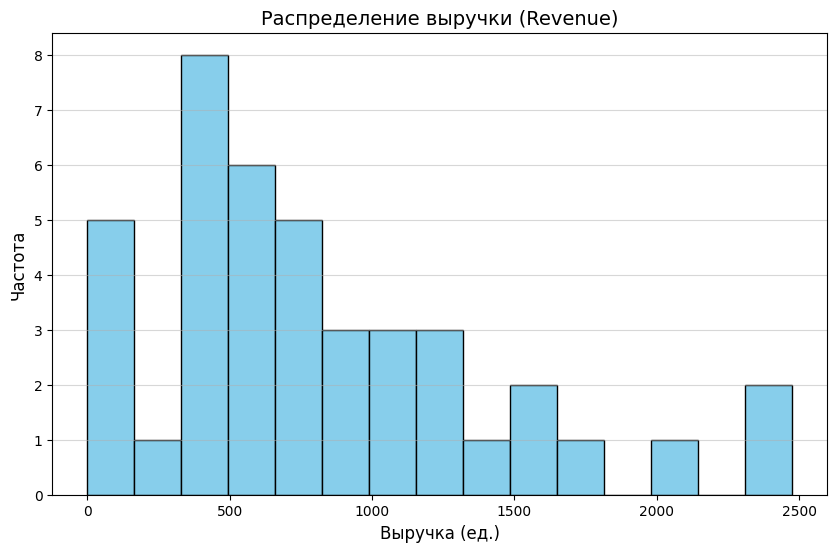

In [100]:
#Гистограмма для выручки с 15 сегментами 

plt.figure(figsize=(10, 6))
plt.hist(data['revenue'].dropna(), bins=15, edgecolor='black', color='skyblue')
plt.title('Распределение выручки (Revenue)', fontsize=14)
plt.xlabel('Выручка (ед.)', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.grid(axis='y', alpha=0.5)
plt.show()

<Figure size 800x600 with 0 Axes>

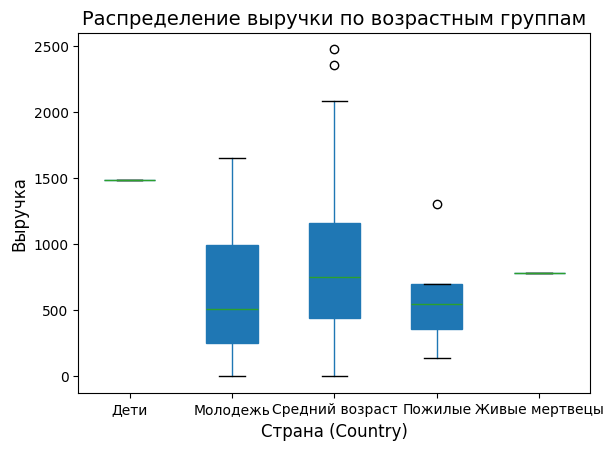

In [99]:
plt.figure(figsize=(8, 6))
data.boxplot(column='revenue', by='Age_Group', grid=False, patch_artist=True)
plt.suptitle('')
plt.title('Распределение выручки по возрастным группам', fontsize=14)
plt.xlabel('Страна (Country)', fontsize=12)
plt.ylabel('Выручка', fontsize=12)

# Сохраняем этот график
save_file_boxplot = os.path.join(figure_path, 'revenue_by_age_group_boxplot.png')
plt.savefig(save_file_boxplot)
plt.show()

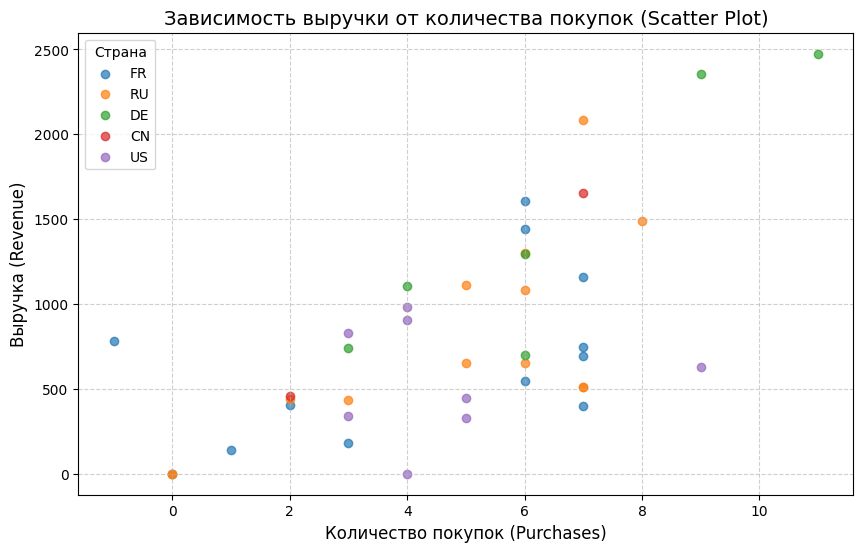

In [97]:
plt.figure(figsize=(10, 6))
countries = data['country'].unique()
for country in countries:
    subset = data[data['country'] == country]
    plt.scatter(subset['purchases'], subset['revenue'], alpha=0.7, label=country)

plt.title('Зависимость выручки от количества покупок (Scatter Plot)', fontsize=14)
plt.xlabel('Количество покупок (Purchases)', fontsize=12)
plt.ylabel('Выручка (Revenue)', fontsize=12)
plt.legend(title='Страна')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()